<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод:</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Вывод:</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Требуется построить модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. 

Дополнительно измерим *AUC-ROC*.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Признаки:**
    
RowNumber — индекс строки в данных

CustomerId — уникальный идентификатор клиента

Surname — фамилия

CreditScore — кредитный рейтинг

Geography — страна проживания

Gender — пол

Age — возраст

Tenure — сколько лет человек является клиентом банка

Balance — баланс на счёте

NumOfProducts — количество продуктов банка, используемых клиентом

HasCrCard — наличие кредитной карты

IsActiveMember — активность клиента

EstimatedSalary — предполагаемая зарплата

Целевой признак

Exited — факт ухода клиента

## Подготовка данных

In [1]:
#импортируем сразу все библиотеки, которые пригодятся
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
df['Tenure'] = df['Tenure'].fillna(1) #заполнил пропуски в столбце "сколько лет человек явдяется клиентом банка" единицей,
#так как возможно пропуски обусловленны тем, что является клиентом менее года

**Привел к целочисленному типу данных, там где это необходимо, тем более, что в цифрах после запятой в этих случаях нет никакой необходимости.** 

In [6]:
df['Tenure'] = df['Tenure'].astype('int')

In [7]:
df['EstimatedSalary'] = df['EstimatedSalary'].astype('int')

In [8]:
df['Balance'] = df['Balance'].astype('int')

**Выполнил порядковое кодирование, чтобы закодировать цифрами выраженные в тексте категории.**

In [9]:
#Преобразовал признаки техникой Ordinal Encoding
encoder = OrdinalEncoder()
encoder.fit(df[['Surname', 'Geography', 'Gender']])
df_ordinal = encoder.transform(df[['Surname', 'Geography', 'Gender']])
df_ordinal = pd.DataFrame(encoder.transform(df[['Surname', 'Geography', 'Gender']]), columns=df[['Surname', 'Geography', 'Gender']].columns)

In [10]:
df_ordinal.head()

,Surname,Geography,Gender
0,1115.0,0.0,0.0
1,1177.0,2.0,0.0
2,2040.0,0.0,0.0
3,289.0,0.0,0.0
4,1822.0,2.0,0.0


In [11]:
df = pd.concat([df,df_ordinal], sort=False, axis=1)#объединил две таблицы - исходную и с закодированными признаками, затем переименовал столбцы
df.columns = ['RowNumber','CustomerId','Surname','CreditScore','Geography','Gender',
              'Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember',
              'EstimatedSalary','Exited','Surname_code','Geography_code','Gender_code']

In [12]:
df = df.drop(['Surname', 'Geography', 'Gender'], axis=1)#удалил те столбцы с текстом, которым уже сделал эквивалентные закодированные

In [13]:
df.head()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Surname_code,Geography_code,Gender_code
0,1,15634602,619,42,2,0,1,1,1,101348,1,1115.0,0.0,0.0
1,2,15647311,608,41,1,83807,1,0,1,112542,0,1177.0,2.0,0.0
2,3,15619304,502,42,8,159660,3,1,0,113931,1,2040.0,0.0,0.0
3,4,15701354,699,39,1,0,2,0,0,93826,0,289.0,0.0,0.0
4,5,15737888,850,43,2,125510,1,1,1,79084,0,1822.0,2.0,0.0


**Разбил данные на три выборки, тренировочную, валидационную и тестовую, в соотношении 6:2:2 соответственно.**

In [14]:
df_train, df_temporary = train_test_split(df, test_size=0.4, random_state=12345)
df_valid, df_test = train_test_split(df_temporary, test_size=0.5, random_state=12345)

In [15]:
#проверим размеры полученных наборов
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(6000, 14)
(2000, 14)
(2000, 14)


## Исследование задачи

**Исследуем баланс классов с помощью мтарицы ошибок, обучим модели без учёта дисбаланса**

In [16]:
# выделил признаки и целевой признак для обучающей и валидационной выборок.
target_valid = df_valid['Exited']
features_valid = df_valid.drop('Exited', axis=1)
target_train = df_train['Exited']
features_train = df_train.drop('Exited', axis=1)

In [17]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(confusion_matrix(target_valid, predicted_valid),'\n') #Рассчитаем матрицу ошибок функцией confusion_matrix()
print(recall_score(target_valid,predicted_valid), '\n')
print(precision_score(target_valid,predicted_valid), '\n')
print(f1_score(target_valid,predicted_valid))

[[1582    0]
 [ 418    0]] 

0.0 

0.0 

0.0


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
#с помощью функции переберем несколько значений параметра max_depth
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print("max_depth =", depth)
    print("полнота:",recall_score(target_valid,predicted_valid), '\n')
    print("точность:",precision_score(target_valid,predicted_valid), '\n')
    print('F1',f1_score(target_valid,predicted_valid), '\n')
print(confusion_matrix(target_valid, predicted_valid))

max_depth = 1
полнота: 0.0 

точность: 0.0 

F1 0.0 

max_depth = 2
полнота: 0.45933014354066987 

точность: 0.6037735849056604 

F1 0.5217391304347825 

max_depth = 3
полнота: 0.284688995215311 

точность: 0.8263888888888888 

F1 0.4234875444839857 

max_depth = 4
полнота: 0.43779904306220097 

точность: 0.75 

F1 0.5528700906344411 



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


max_depth = 5
полнота: 0.38516746411483255 

точность: 0.8009950248756219 

F1 0.5201938610662359 

[[1542   40]
 [ 257  161]]


In [19]:
#с помощью функции переберем несколько значений параметра n_estimators
for est in range(1, 50, 5):
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    model.fit(features_train, target_train) 
    predicted_valid = model.predict(features_valid)
    print("n_estimators =", est)
    print("полнота:",recall_score(target_valid,predicted_valid), '\n')
    print("точность:",precision_score(target_valid,predicted_valid), '\n')
    print('F1',f1_score(target_valid,predicted_valid), '\n')
print(confusion_matrix(target_valid, predicted_valid))

n_estimators = 1
полнота: 0.45454545454545453 

точность: 0.4481132075471698 

F1 0.4513064133016627 

n_estimators = 6
полнота: 0.3827751196172249 

точность: 0.6986899563318777 

F1 0.4945904173106645 

n_estimators = 11
полнота: 0.47129186602870815 

точность: 0.7323420074349443 

F1 0.5735080058224163 

n_estimators = 16
полнота: 0.44019138755980863 

точность: 0.7634854771784232 

F1 0.5584218512898331 

n_estimators = 21
полнота: 0.46172248803827753 

точность: 0.7423076923076923 

F1 0.5693215339233039 

n_estimators = 26
полнота: 0.44258373205741625 

точность: 0.7676348547717843 

F1 0.5614567526555386 

n_estimators = 31
полнота: 0.4449760765550239 

точность: 0.7410358565737052 

F1 0.5560538116591928 

n_estimators = 36
полнота: 0.42822966507177035 

точность: 0.7748917748917749 

F1 0.551617873651772 

n_estimators = 41
полнота: 0.4354066985645933 

точность: 0.7583333333333333 

F1 0.5531914893617021 

n_estimators = 46
полнота: 0.42105263157894735 

точность: 0.782222222

**Исходя из результатов можно сделать вывод, что модели часто дают ложно-отрицательные ответы.**

## Борьба с дисбалансом

**Попробуем улучшить качество модели, учитывая дисбаланс классов.**

In [20]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4923076923076924


**Метрика F1 все еще недопустимо мала, по заданию нам требуется F1>=0.59**

**Узнаем количество объектов редкого класса, и затем техникой upsampling сделаем их не такими редкими.**

In [21]:
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones  = target_train[target_train == 1]


print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(4804, 13)
(1196, 13)
(4804,)
(1196,)


**Преобразование проходит в несколько этапов:**

1) Разделим обучающую выборку на отрицательные и положительные объекты;

2) Скопируем несколько раз положительные объекты;

3) С учётом полученных данных создадим новую обучающую выборку;

4) Перемешаем данные функцией shuffle().

In [22]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4973637961335676


**Метрика F1 все еще недопустимо мала.**

**Теперь воспользуемся техникой downsampling, чтобы сделать объекты частого класса не такими частыми.**

**Преобразование проходит в несколько этапов:**

1) Разделим обучающую выборку на отрицательные и положительные объекты;

2) Случайным образом отбросим часть из отрицательных объектов, применив для этого функцию sample();

3) С учётом полученных данных создадим новую обучающую выборку;

4) Перемешаем данные. Положительные не должны идти следом за отрицательными: алгоритмам будет сложнее обучаться.

In [23]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.2)

model = LogisticRegression(random_state=12345,solver='liblinear', class_weight='balanced')
model.fit(features_downsampled,target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.48406546080964685


**Пока не удалось достич необходимого значения метрики F1**

**Изменим значение порога и посмотрим, какой станет метрика F1. Изменять вероятность классов будем функцией predict_proba. Также чтобы выявить, как сильно наша модель отличается от случайной, узнаем величину метрики AUC-ROC(у случайной модели она равна 0.5)** 

In [24]:
model = LogisticRegression(random_state=12345,solver='liblinear', class_weight='balanced')
model.fit(features_train,target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | F1 = {:.3f}".format(threshold, f1))
    
auc_roc = roc_auc_score(target_valid, probabilities_one_valid) #функция для расчета метрики AUC-ROC
print()
print(auc_roc)

Порог = 0.00 | F1 = 0.346
Порог = 0.02 | F1 = 0.346
Порог = 0.04 | F1 = 0.346
Порог = 0.06 | F1 = 0.346
Порог = 0.08 | F1 = 0.346
Порог = 0.10 | F1 = 0.346
Порог = 0.12 | F1 = 0.347
Порог = 0.14 | F1 = 0.349
Порог = 0.16 | F1 = 0.351
Порог = 0.18 | F1 = 0.353
Порог = 0.20 | F1 = 0.360
Порог = 0.22 | F1 = 0.365
Порог = 0.24 | F1 = 0.368
Порог = 0.26 | F1 = 0.376
Порог = 0.28 | F1 = 0.389
Порог = 0.30 | F1 = 0.396
Порог = 0.32 | F1 = 0.406
Порог = 0.34 | F1 = 0.416
Порог = 0.36 | F1 = 0.421
Порог = 0.38 | F1 = 0.438
Порог = 0.40 | F1 = 0.449
Порог = 0.42 | F1 = 0.454
Порог = 0.44 | F1 = 0.464
Порог = 0.46 | F1 = 0.468
Порог = 0.48 | F1 = 0.477

0.7449083287462421


### Вывод:
**Нам так и не удалось достигнуть подходящей величины метрики F1 для модели логистической регрессии.**

**Теперь применим все те же методы и техники, которые мы использовали на модели логистической регрессии, но уже для модели дерева решений.**

In [25]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5839572192513369


**Снова видим низкий F1**

In [26]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5839572192513369


**Переберем с помощью функции параметр max_depth для модели дерево решений на признаках после апсемплинга.**

In [27]:
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    print("max_depth =", depth, ": ", end='')
    print("F1:", f1_score(target_valid, predicted_valid))

max_depth = 1 : F1: 0.4994903160040775
max_depth = 2 : F1: 0.541015625
max_depth = 3 : F1: 0.541015625
max_depth = 4 : F1: 0.524239934264585
max_depth = 5 : F1: 0.5839572192513369
max_depth = 6 : F1: 0.5475763016157988
max_depth = 7 : F1: 0.527651858567543
max_depth = 8 : F1: 0.5323047251687562
max_depth = 9 : F1: 0.510879848628193


**Лучший результат F1=0.58 для max_depth = 5. Техника upsample не подходит, хотя значение F1 достигало 0.58**

In [28]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5439856373429084


**Техника downsample не подходит**

**Сделаем перебор порога с помощью функции**

In [29]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
for threshold in np.arange(0, 0.7, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | F1 = {:.3f}".format(threshold, f1))
    
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print()
print(auc_roc)    

Порог = 0.00 | F1 = 0.337
Порог = 0.02 | F1 = 0.337
Порог = 0.04 | F1 = 0.375
Порог = 0.06 | F1 = 0.375
Порог = 0.08 | F1 = 0.375
Порог = 0.10 | F1 = 0.375
Порог = 0.12 | F1 = 0.375
Порог = 0.14 | F1 = 0.392
Порог = 0.16 | F1 = 0.403
Порог = 0.18 | F1 = 0.404
Порог = 0.20 | F1 = 0.438
Порог = 0.22 | F1 = 0.438
Порог = 0.24 | F1 = 0.438
Порог = 0.26 | F1 = 0.474
Порог = 0.28 | F1 = 0.474
Порог = 0.30 | F1 = 0.474
Порог = 0.32 | F1 = 0.474
Порог = 0.34 | F1 = 0.474
Порог = 0.36 | F1 = 0.496
Порог = 0.38 | F1 = 0.496
Порог = 0.40 | F1 = 0.496
Порог = 0.42 | F1 = 0.496
Порог = 0.44 | F1 = 0.523
Порог = 0.46 | F1 = 0.584
Порог = 0.48 | F1 = 0.584
Порог = 0.50 | F1 = 0.584
Порог = 0.52 | F1 = 0.584
Порог = 0.54 | F1 = 0.584
Порог = 0.56 | F1 = 0.584
Порог = 0.58 | F1 = 0.595
Порог = 0.60 | F1 = 0.595
Порог = 0.62 | F1 = 0.595
Порог = 0.64 | F1 = 0.595
Порог = 0.66 | F1 = 0.595
Порог = 0.68 | F1 = 0.539

0.8053641747167597


### Вывод:
**Подходящий уровень метрики F1 встречается при переборе порога на модели дерево решений**

**Теперь все те же техники применим к модели случайный лес**

In [30]:
model = RandomForestClassifier(random_state=12345, n_estimators=50, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5237315875613747


**F1 уже выше, но недостаточно**

In [31]:
model = RandomForestClassifier(random_state=12345, n_estimators=30, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5589887640449438


**Техника upsample сильно улучшила показатель F1**

In [32]:
model = RandomForestClassifier(random_state=12345, n_estimators=50, class_weight='balanced')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5618556701030928


**Техника downsample все еще не дает нам подходящее значение метрики F1**

**Переберем с помощью функции параметр n_estimators для модели случайного леса на признаках после даунсемплинга.**

In [33]:
for est in range(1, 50, 5):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, class_weight='balanced') 
    model.fit(features_downsampled, target_downsampled) 
    predicted_valid = model.predict(features_valid)
    print("n_estimators =", est, ": ", end='')
    print('F1 =',f1_score(target_valid,predicted_valid))

n_estimators = 1 : F1 = 0.450920245398773
n_estimators = 6 : F1 = 0.5314814814814814
n_estimators = 11 : F1 = 0.5305126118795769
n_estimators = 16 : F1 = 0.5473501303214596
n_estimators = 21 : F1 = 0.5439469320066336
n_estimators = 26 : F1 = 0.5520833333333334
n_estimators = 31 : F1 = 0.5512073272273106
n_estimators = 36 : F1 = 0.5558397271952259
n_estimators = 41 : F1 = 0.5552784704904407
n_estimators = 46 : F1 = 0.5636208368915456


**Лучший результат F1=0.56 для n_estimators = 46.**

In [34]:
model = RandomForestClassifier(random_state=12345, n_estimators=30, class_weight='balanced')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | F1 = {:.3f}".format(threshold, f1))
    
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print()
print(auc_roc)        

Порог = 0.00 | F1 = 0.371
Порог = 0.02 | F1 = 0.371
Порог = 0.04 | F1 = 0.407
Порог = 0.06 | F1 = 0.407
Порог = 0.08 | F1 = 0.446
Порог = 0.10 | F1 = 0.485
Порог = 0.12 | F1 = 0.485
Порог = 0.14 | F1 = 0.512
Порог = 0.16 | F1 = 0.512
Порог = 0.18 | F1 = 0.549
Порог = 0.20 | F1 = 0.583
Порог = 0.22 | F1 = 0.583
Порог = 0.24 | F1 = 0.604
Порог = 0.26 | F1 = 0.604
Порог = 0.28 | F1 = 0.602
Порог = 0.30 | F1 = 0.613
Порог = 0.32 | F1 = 0.613
Порог = 0.34 | F1 = 0.606
Порог = 0.36 | F1 = 0.606
Порог = 0.38 | F1 = 0.587
Порог = 0.40 | F1 = 0.571
Порог = 0.42 | F1 = 0.571
Порог = 0.44 | F1 = 0.550
Порог = 0.46 | F1 = 0.550
Порог = 0.48 | F1 = 0.538

0.8247547166387408


**Изменяя порог можно заметить высокий показатели метрики F1 до 0.61 и высокий показатель метрики auc-roc**

### Вывод:
**Модель случайный лес дает нам самый высокий показатель метрики F1.**

## Тестирование модели

**Модели случайный лес и дерево решений дали нам подходящий уровень метрики F1 при переборе порогов, проверим модель дерево решений с порогом 0.58 для тестовой выборки**

In [35]:
#Создадим признаки и целевой признак для тестовой выборки
target_test = df_test['Exited']
features_test = df_test.drop('Exited', axis=1)

In [36]:
threshold = 0.58
model = DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
predicted_test = probabilities_one_test > threshold
f1 = f1_score(target_test, predicted_test)
print("Порог = {:.2f} | F1 = {:.3f}".format(threshold, f1))
    
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print()
print(auc_roc)    

Порог = 0.58 | F1 = 0.600

0.826375303378501


**Получили подходящее значение F1=0.6, теперь визуализируем ROC-кривую.**

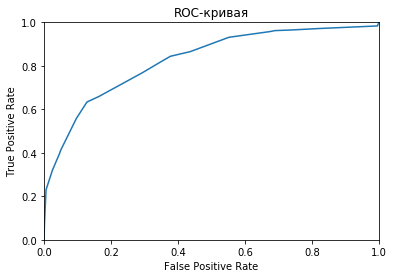

In [37]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 


## Вывод:
**Нам были предоставленны данные о 10 тысячах клиентах банка, в предоставленных данных практически не было пропусков, только в столбце "сколько лет человек был клиентом банка" мы заполнили пропуск единицей. Для кодирования некоторых признаков была применена техника Ordinal Encoding. Для борьбы с дисбалансом классов использовали балансирование веса классов, ресемплинг, изменение порога вероятности класса. Применив модели машинного обучения, мы построили модель с предельно большим значением F1-меры, доведя эту  метрику на тестовой выборке до значения 0.6. Также мы получили достаточно высокое значение метрики AUC-ROC = 0.82, при том, что для случайной модели данная метрика равна 0.5.**